#### SSPD

The Symmetric Segment Path Distance (SSPD) [20] is a shape-based distance that is dependent on the point-to-segment distance similar to the Hausdorff. The SSPD distance computes the minimum point-to-segment distance for every point of the first trajectory in all segments of the other one. Afterward, the average of the computed distance of every trajectory point is reported as SSPD distance.

Propuesto en:
- Besse, P.; Guillouet, B.; Loubes, J.M.; Royer, F. Review & Perspective for Distance Based Clustering of Vehicle Trajectories. IEEE Trans. Intell. Transp. Syst. 2016, 17, 3306–3317.

Comparado con la ditancia euclidiana en:
- Basora, L.; Morio, J.; Mailhot, C. A Trajectory Clustering Framework to Analyse Air Traffic Flows. In Proceedings of the 7th SESAR Innovation Days, Belgrade, Serbia, 28–30 November 2017

Tiene una gran tiempo de computo. Esto podría ser un problema a la hora de utilizarlo en aplicaciones reales



#### DBI vs Silhouette

El índice Davies-Bouldin (DBI) y la métrica de silueta son métodos de evaluación interna utilizados para medir la calidad de una agrupación. Ambos proporcionan una medida de lo bien que ha sido agrupado cada objeto.

El DBI se define como la medida de similitud promedio de cada grupo con su grupo más similar, donde la similitud es la relación entre las distancias dentro del grupo y las distancias entre grupos. Los grupos que están más alejados y menos dispersos darán como resultado una mejor puntuación. La puntuación mínima es cero, con valores más bajos que indican una mejor agrupación.

Por otro lado, la métrica de silueta mide similitud de un objeto con su propio grupo (cohesión) en comparación con otros grupos (separación). El valor de silueta varía de -1 a +1, donde un valor alto indica que el objeto está bien emparejado con su propio grupo y mal emparejado con los grupos vecinos. Si la mayoría de los objetos tienen un valor alto, entonces la configuración de agrupación es adecuada. Si muchos puntos tienen un valor bajo o negativo, entonces la configuración de agrupación puede tener demasiados o muy pocos grupos.

#### Davies-bouldin index
- Davies, D. L., & Bouldin, D. W. (1979). A Cluster Separation Measure. IEEE Transactions on Pattern Analysis and Machine Intelligence, PAMI-1(2), 224-227.

#### Silhouette metric

- Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. Journal of Computational and Applied Mathematics, 20, 53-65.

In [1]:
import os

departure = 'LEMD'
destinations = [
  'LEAS',
  'LEBB',
  'LEBL',
  'LECO',
  'LEGR',
  'LEJR'
]

root_path = os.getcwd()
flights_path = os.path.join(root_path, 'Flights')
flights_points_path = os.path.join(root_path, 'Flight_Points')
flights_filename = os.path.join(root_path, 'flights.csv')
flights_points_filename = os.path.join(root_path, 'flight_points.csv')

In [2]:
import pandas as pd

flights = []

for root, dirs, files in os.walk(flights_path, topdown=False):
   for name in files:
      filepath = os.path.join(root, name)
      print(filepath)
      dataset = pd.read_csv(filepath, compression='gzip')
      # Filter -  Vuelos entre Madrid y Barcelona
      flights = dataset[(dataset['ADEP'] == departure) & (dataset['ADES'].isin(destinations))]

/Users/rodrigo/Proyectos/TFM/Flights/Flights_20150301_20150331.csv.gz


In [3]:
import pandas as pd

flight_points = []

for root, dirs, files in os.walk(flights_points_path, topdown=False):
   for name in files:
      filepath = os.path.join(root, name)
      print(filepath)
      dataset = pd.read_csv(filepath, compression='gzip')
      # Filter - Puntos que pertenezcan a alguno de los vuelos guardados arriba
      flight_points = dataset[dataset['ECTRL ID'].isin(flights['ECTRL ID'])]

/Users/rodrigo/Proyectos/TFM/Flight_Points/flight_points.csv.gz


In [4]:
from utils.trajectories import df_to_trajectories, remove_taxi, interpolate_trajectory

# Preparar los datos, transforma tus datos de puntos a trayectorias
trajectories = df_to_trajectories(flight_points)
trajectories = [remove_taxi(trajectory) for trajectory in trajectories]
points_num = max([len(trajectory) for trajectory in trajectories])
trajectories = [interpolate_trajectory(trajectory, points_num) for trajectory in trajectories]

In [5]:
import traj_dist.distance as tdist
import numpy as np

_trajectories = [np.array([point.coords for point in trajectory]) for trajectory in trajectories]

# Calcula la matriz de distancias entre las trayectorias utilizando la distancia SSPD
sspd_distances = np.zeros((len(_trajectories), len(_trajectories)))
for i in range(len(_trajectories)):
    for j in range(i+1, len(_trajectories)):
        d = tdist.sspd(_trajectories[i], _trajectories[j])
        sspd_distances[i,j] = d
        sspd_distances[j,i] = d

In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import DBSCAN
from itertools import product
import pandas as pd

eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_list = [1, 2, 3, 5, 7, 10, 15]

results = []
for eps, min_samples in product(eps_list, min_samples_list):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = DBSCAN(metric='precomputed', eps = eps, min_samples = min_samples)
  clusterer.fit(sspd_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  results.append([eps, min_samples, labels])

table = []
for eps, min_samples, labels in results:
  n_outliers = np.sum(labels == -1)

  if len(set(labels)) > 1:
    table.append({
      "min_samples": min_samples,
      "eps": eps,
      "clusters": len(set(labels)),
      "outliers": n_outliers,
      "noise": 100 * n_outliers / len(labels),
      "silhouette": silhouette_score(sspd_distances, labels),
      "davies_bouldin": davies_bouldin_score(sspd_distances, labels)
    })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False))


    min_samples  eps  clusters  outliers     noise  silhouette  davies_bouldin
3             5  0.1         8        10  0.584795    0.965549        0.820319
4             7  0.1         8        10  0.584795    0.965549        0.820319
25            7  0.4         7         3  0.175439    0.963387        0.941067
26           10  0.4         7         3  0.175439    0.963387        0.941067
24            5  0.4         7         3  0.175439    0.963387        0.941067
23            3  0.4         7         3  0.175439    0.963387        0.941067
27           15  0.4         7         3  0.175439    0.963387        0.941067
20           15  0.3         7         4  0.233918    0.961974        0.808231
19           10  0.3         7         4  0.233918    0.961974        0.808231
18            7  0.3         7         4  0.233918    0.961974        0.808231
16            3  0.3         7         4  0.233918    0.961974        0.808231
17            5  0.3         7         4  0.233918  

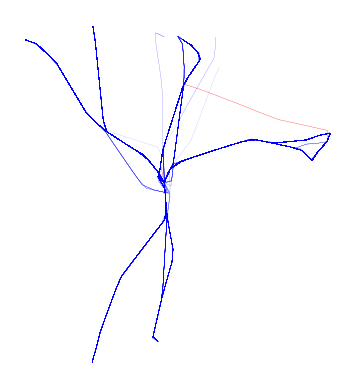

In [7]:
from utils.graphs import show_outliers_map

clusterer = DBSCAN(metric='precomputed', eps = 0.4, min_samples = 2)
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, "graphs/trajectories/outliers_sspd_dbscan.png")

In [8]:
import hdbscan
from sklearn.metrics import silhouette_score
import pandas as pd

"""
Lo ideal es obtener el mayor coef. de silueta con el menor ruido posible. Estos no 
deberían superar el 20% y como mínimo, el nivel de silueta no debería bajar
de 50%
"""

results = []
for cluster_size in [2, 5, 10, 20, 40, 60, 80, 100, 120, 140]:
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size = cluster_size)
  clusterer.fit(sspd_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  results.append((cluster_size, labels))

table = []
for cluster_size, labels in results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_clusters_size": cluster_size,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(sspd_distances, labels),
    "davies_bouldin": davies_bouldin_score(sspd_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False))


   min_clusters_size  clusters  outliers     noise  silhouette  davies_bouldin
0                  2        27        13  0.760234    0.979972        0.900481
6                 80         9         7  0.409357    0.964545        0.653092
7                100         8         1  0.058480    0.962714        0.059138
8                120         8         1  0.058480    0.962714        0.059138
1                  5        19        20  1.169591    0.956566        0.825092
4                 40        11        24  1.403509    0.944349        0.813752
5                 60        11        26  1.520468    0.942438        0.817394
2                 10        16        32  1.871345    0.940260        0.789448
3                 20        13        25  1.461988    0.920756        0.772167
9                140         6         1  0.058480    0.900285        0.224405


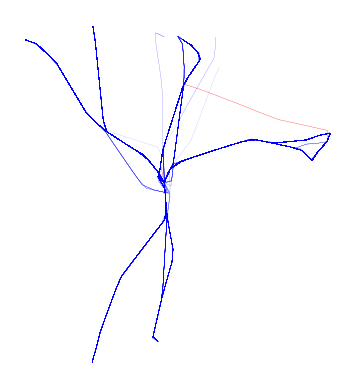

In [9]:
from utils.graphs import show_outliers_map

clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size = 100)
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, "graphs/trajectories/outliers_sspd_hdbscan.png")

In [10]:
import traj_dist.distance as tdist
import numpy as np

_trajectories = [np.array([np.array([point.coords[1], point.coords[0]]) for point in trajectory]) for trajectory in trajectories]
g = np.zeros(_trajectories[0].shape[1], dtype=float)

erp_distances = np.zeros((len(_trajectories), len(_trajectories)))
for i in range(len(_trajectories)):
    for j in range(i+1, len(_trajectories)):
        d = tdist.erp(_trajectories[i], _trajectories[j], type_d = "spherical", g=g)
        erp_distances[i,j] = d
        erp_distances[j,i] = d

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from itertools import product
import pandas as pd

eps_list = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_list = [1, 2, 3, 5, 7, 10, 15]

results = []
for eps, min_samples in product(eps_list, min_samples_list):
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = DBSCAN(metric='precomputed', eps = eps, min_samples = min_samples)
  clusterer.fit(erp_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  results.append([eps, min_samples, labels])

table = []
for eps, min_samples, labels in results:
  n_outliers = np.sum(labels == -1)

  if len(set(labels)) > 1:
    table.append({
      "min_samples": min_samples,
      "eps": eps,
      "clusters": len(set(labels)),
      "outliers": n_outliers,
      "noise": 100 * n_outliers / len(labels),
      "silhouette": silhouette_score(erp_distances, labels),
      "davies_bouldin": davies_bouldin_score(sspd_distances, labels)
    })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False))

    min_samples  eps  clusters  outliers     noise  silhouette  davies_bouldin
0             1  0.1        40         0  0.000000    0.988997        0.003497
14            1  0.3        40         0  0.000000    0.988997        0.003497
21            1  0.4        40         0  0.000000    0.988997        0.003497
28            1  0.5        40         0  0.000000    0.988997        0.003497
7             1  0.2        40         0  0.000000    0.988997        0.003497
1             2  0.1        29        12  0.701754    0.985039        1.022504
15            2  0.3        29        12  0.701754    0.985039        1.022504
22            2  0.4        29        12  0.701754    0.985039        1.022504
8             2  0.2        29        12  0.701754    0.985039        1.022504
29            2  0.5        29        12  0.701754    0.985039        1.022504
9             3  0.2        26        18  1.052632    0.978862        0.927132
23            3  0.4        26        18  1.052632  

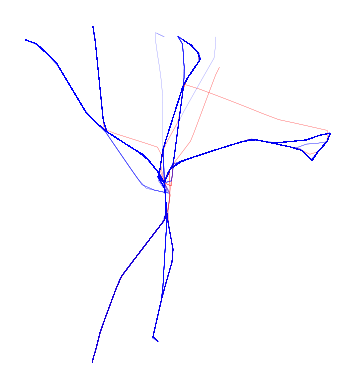

In [12]:
from utils.graphs import show_outliers_map

clusterer = DBSCAN(metric='precomputed', eps = 0.5, min_samples = 2)
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, "graphs/trajectories/outliers_erp_dbscan.png")

   min_clusters_size  clusters  outliers     noise  silhouette  davies_bouldin
0                  2        26        12  0.701754    0.984860        0.892678
5                 60        10        19  1.111111    0.976159        0.504936
1                  5        20        19  1.111111    0.975588        0.932645
6                 80         9         7  0.409357    0.970872        0.653092
7                100         8         1  0.058480    0.967351        0.059138
8                120         8         1  0.058480    0.967351        0.059138
2                 10        16        36  2.105263    0.954644        0.873308
3                 20        13        55  3.216374    0.932197        0.863967
4                 40        11        51  2.982456    0.930149        0.799831
9                140         6         1  0.058480    0.914503        0.224405


In [ ]:
from sklearn.metrics import silhouette_score

"""
Lo ideal es obtener el mayor coef. de silueta con el menor ruido posible. 
Segun Andrew Churchill and Michael Bloem, Hierarchical clustering of aircraft 
surface trajectories, AIAA AVIATION 2020 FORUM., los niveles de ruido no 
deberían superar el 20% y como mínimo, el nivel coef de silueta no debería bajar
de 50%
"""

erp_results = []
for cluster_size in [2, 5, 10, 20, 40, 60, 80, 100, 120, 140]:
  # Ajusta el modelo HDBSCAN utilizando la matriz de distancias
  clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size = cluster_size)
  clusterer.fit(erp_distances)

  # Obtiene las etiquetas de los clusters para cada trayectoria
  labels = clusterer.labels_
  erp_results.append((cluster_size, labels))

table = []
for cluster_size, labels in erp_results:
  n_outliers = np.sum(labels == -1)
  table.append({
    "min_clusters_size": cluster_size,
    "clusters": len(set(labels)),
    "outliers": n_outliers,
    "noise": 100 * n_outliers / len(labels),
    "silhouette": silhouette_score(erp_distances, labels),
    "davies_bouldin": davies_bouldin_score(sspd_distances, labels)
  })

print(pd.DataFrame(table).sort_values(by='silhouette', ascending=False))


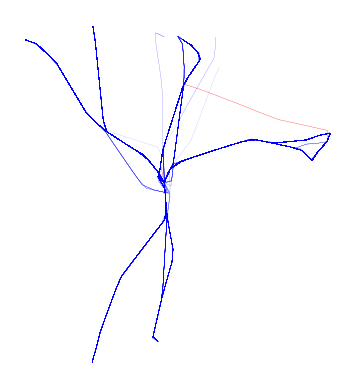

In [14]:
from utils.graphs import show_outliers_map

clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size = 100)
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, "graphs/trajectories/outliers_erp_hdbscan.png")

In [48]:
import folium
from selenium import webdriver
# import io
# from PIL import Image

# Create a map centered at the average coordinates of the trajectories
# avg_lat = sum(p.latitude for t in trajectories for p in t) / len(trajectories)
# avg_lon = sum(p.longitude for t in trajectories for p in t) / len(trajectories)
# m1 = folium.Map(location=[avg_lat, avg_lon], zoom_start=6, tiles='Stamen Terrain')

m1 = folium.Map(location=[trajectories[0][0].latitude, trajectories[0][0].longitude], zoom_start=7, tiles='Stamen Toner', zoom_control=False)



# Add the trajectories to the map
for i, t in enumerate(trajectories):
    # Choose a color based on whether the trajectory is anomalous
    color = 'red' if labels[i] == -1 else 'blue'
    # Set the line weight and opacity
    weight = 3 if labels[i] == -1 else 1
    opacity = 1 if labels[i] == -1 else 0.3
    folium.PolyLine([(p.latitude, p.longitude) for p in t], color=color, weight=weight, opacity=opacity).add_to(m1)

# Create another map to show only the anomalous trajectories
# m2 = folium.Map(location=[avg_lat, avg_lon], zoom_start=6)
# for i, t in enumerate(trajectories):
#     if labels[i] == -1:
#         # Set the line weight and opacity
#         weight = 5
#         opacity = 1
#         folium.PolyLine([(p.latitude, p.longitude) for p in t], color='red', weight=weight, opacity=opacity).add_to(m2)
# m2

# Display the maps
m1
# m1.save('maps/map2.html')

# # Use selenium to open the HTML file and take a screenshot
# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
# driver = webdriver.Chrome(executable_path='/Users/rodrigo/Proyectos/TFM/drivers/chromedriver_mac64/chromedriver', options=options)
# driver.get('/Users/rodrigo/Proyectos/TFM/maps/map2.html')
# driver.save_screenshot('graphs/map.png')
# driver.quit()
